In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from pycaret.classification import ClassificationExperiment
from pycaret.classification import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap

DATA_PATH = "./data/pet_store_records_2020.csv"

# Read data

In [2]:
datasheet = pd.read_csv(DATA_PATH, sep=",", index_col=0)
datasheet.head()

,product_category,sales,price,VAP,vendor_id,country,pet_size,pet_type,rating,re_buy
product_id,,,,,,,,,,
5040,Equipment,123,7293,0,VC_1605,Vietnam,small,fish,7,1
4567,Toys,61,9304,1,VC_1132,India,small,cat,10,0
4237,Toys,218,8180,0,VC_802,India,small,hamster,6,0
4364,Snack,69,18559,1,VC_929,India,large,dog,1,1
4184,Supplements,138,10283,1,VC_749,India,large,dog,10,0


In [3]:
datasheet['pet_size'].unique()

array(['small', 'large', 'extra_small', 'medium', 'extra_large'],
      dtype=object)

In [4]:
datasheet = datasheet.drop([
    'vendor_id', 
    'rating', 
    'country', 
], axis=1)
datasheet.head()

,product_category,sales,price,VAP,pet_size,pet_type,re_buy
product_id,,,,,,,
5040,Equipment,123,7293,0,small,fish,1
4567,Toys,61,9304,1,small,cat,0
4237,Toys,218,8180,0,small,hamster,0
4364,Snack,69,18559,1,large,dog,1
4184,Supplements,138,10283,1,large,dog,0


In [5]:
datasheet['pet_type'].unique()

array(['fish', 'cat', 'hamster', 'dog', 'bird', 'rabbit'], dtype=object)

### Plotting for analysis

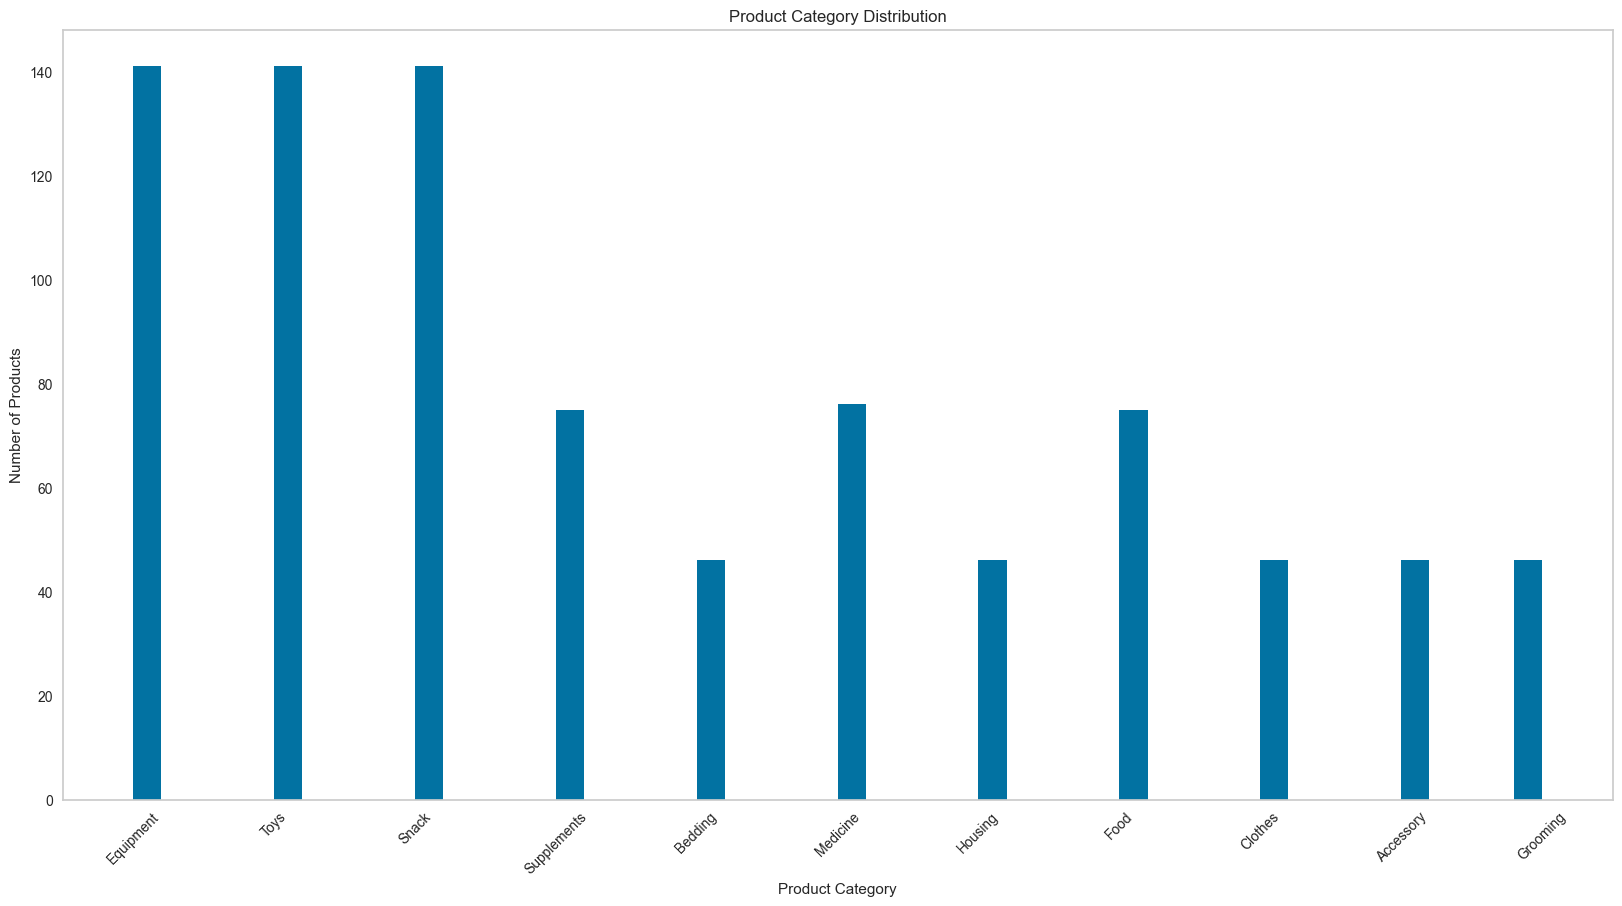

In [6]:
plt.figure(figsize=(20, 10))
plt.hist(datasheet['product_category'], bins=50)
plt.grid()
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Product Category Distribution')
plt.xticks(rotation=45)
plt.show()

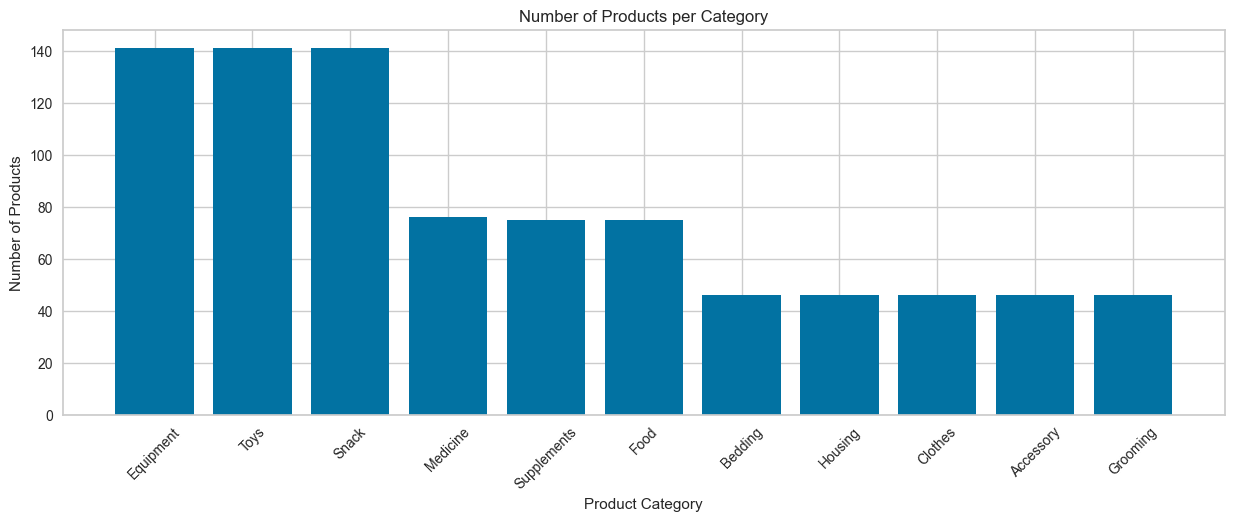

In [7]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index, rotation=45)
plt.grid(True)
plt.show()

# Pre-processing

### Product Category Pre-processing

In [8]:
product_category = datasheet['product_category'].unique()
grouped_category_target = {
    'Lifestyle' : ['Equipment', 'Housing', 'Bedding'],
    'Food' : ['Food', 'Snack'],
    'Grooming' : ['Grooming'],
    'Medicine' : ['Medicine', 'Supplements'],
    'Clothes' : ['Clothes', 'Accessory'],
    'Toys' : ['Toys'],
}

def get_category(category):
    for key, value in grouped_category_target.items():
        if category in value:   return key
    print(f'Unknown category: {category}')
    return 'Others'

datasheet['product_category'] = datasheet['product_category'].apply(get_category)
print(datasheet['product_category'].unique())

['Lifestyle' 'Toys' 'Food' 'Medicine' 'Clothes' 'Grooming']


In [9]:
datasheet.head(10)

,product_category,sales,price,VAP,pet_size,pet_type,re_buy
product_id,,,,,,,
5040,Lifestyle,123,7293,0,small,fish,1
4567,Toys,61,9304,1,small,cat,0
4237,Toys,218,8180,0,small,hamster,0
4364,Food,69,18559,1,large,dog,1
4184,Medicine,138,10283,1,large,dog,0
4609,Lifestyle,183,3969,1,large,cat,0
4380,Toys,79,13519,1,extra_small,dog,0
4389,Lifestyle,205,13078,0,large,cat,0
4697,Medicine,116,13701,0,small,cat,0


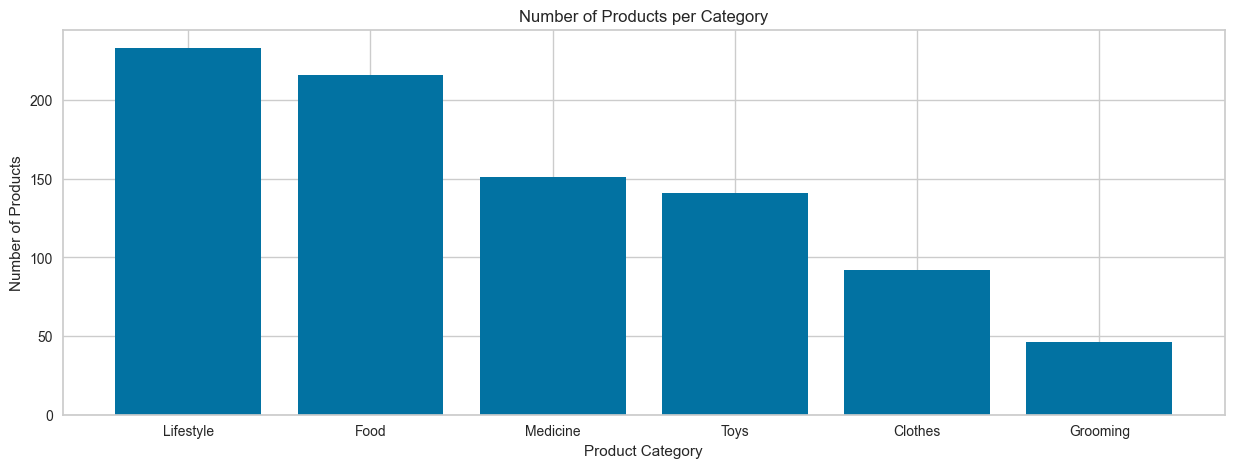

In [10]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['product_category'].value_counts())), height=datasheet['product_category'].value_counts())
plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Number of Products per Category')
plt.xticks(range(len(datasheet['product_category'].value_counts())), datasheet['product_category'].value_counts().index)
plt.grid(True)
plt.show()

In [11]:
org_product_category = datasheet['product_category'].to_list()
product_category_uni = datasheet['product_category'].unique()
product_category_uni_code = [i for i in range(len(product_category_uni))]
for i in range(len(product_category_uni)):  print(f"[{product_category_uni[i]}]\t->\t[{product_category_uni_code[i]}]")

product_category = []
for i in range(len(org_product_category)):
    for j in range(len(product_category_uni)):
        if org_product_category[i] == product_category_uni[j]:
            product_category.append(product_category_uni_code[j])

datasheet['product_category'] = product_category

[Lifestyle]	->	[0]
[Toys]	->	[1]
[Food]	->	[2]
[Medicine]	->	[3]
[Clothes]	->	[4]
[Grooming]	->	[5]


### Pet Type Pre-processing

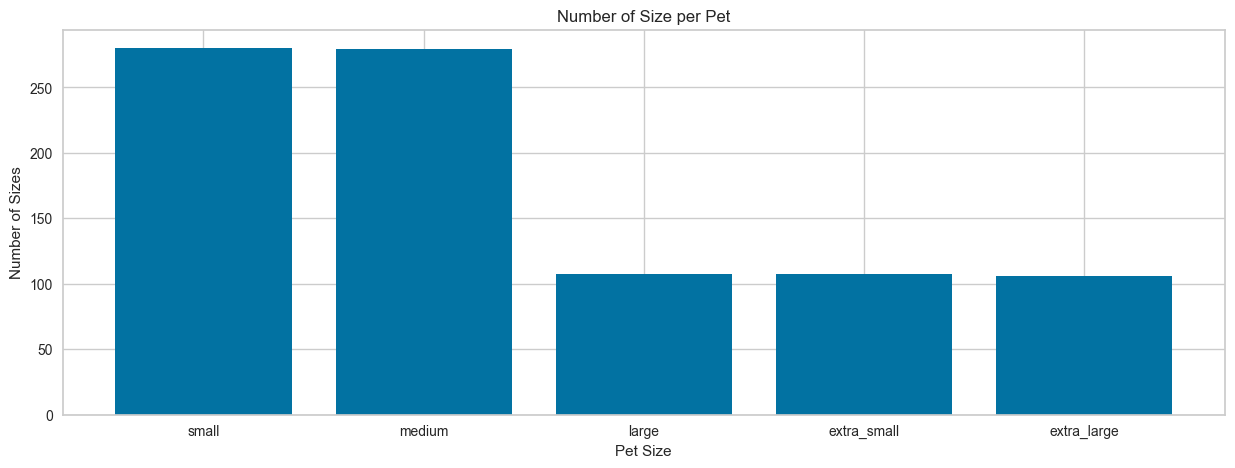

In [12]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(len(datasheet['pet_size'].value_counts())), height=datasheet['pet_size'].value_counts())
plt.xlabel('Pet Size')
plt.ylabel('Number of Sizes')
plt.title('Number of Size per Pet')
plt.xticks(range(len(datasheet['pet_size'].value_counts())), datasheet['pet_size'].value_counts().index)
plt.grid(True)
plt.show()

In [13]:
org_pet_type = datasheet['pet_type'].to_list()
pet_type_uni = datasheet['pet_type'].unique()
pet_type_uni_code = [i for i in range(len(pet_type_uni))]
for i in range(len(pet_type_uni)):  print(f"[{pet_type_uni_code[i]}]\t->\t{pet_type_uni[i]}")

pet_type = []
for i in range(len(org_pet_type)):
    for j in range(len(pet_type_uni)):
        if org_pet_type[i] == pet_type_uni[j]:
            pet_type.append(pet_type_uni_code[j])

datasheet['pet_type'] = pet_type

[0]	->	fish
[1]	->	cat
[2]	->	hamster
[3]	->	dog
[4]	->	bird
[5]	->	rabbit


### Pet Size Pre-processing

In [14]:
org_pet_size = datasheet['pet_size'].to_list()
pet_size_uni = datasheet['pet_size'].unique()
pet_size_uni_code = [i for i in range(len(pet_size_uni))]
for i in range(len(pet_size_uni)):  print(f"{org_pet_size[i]}\t->\t{pet_size_uni_code[i]}")

pet_size = []
for i in range(len(org_pet_size)):
    for j in range(len(pet_size_uni)):
        if org_pet_size[i] == pet_size_uni[j]:
            pet_size.append(pet_size_uni_code[j])

datasheet['pet_size'] = pet_size

small	->	0
small	->	1
small	->	2
large	->	3
large	->	4


### Check for validate

In [15]:
datasheet.head()

,product_category,sales,price,VAP,pet_size,pet_type,re_buy
product_id,,,,,,,
5040,0,123,7293,0,0,0,1
4567,1,61,9304,1,0,1,0
4237,1,218,8180,0,0,2,0
4364,2,69,18559,1,1,3,1
4184,3,138,10283,1,1,3,0


In [16]:
datasheet.to_csv('./data/processed_dataset.csv')

# Train, Test(Validation) Split

In [17]:
print(datasheet.columns)
target = "product_category"

Index(['product_category', 'sales', 'price', 'VAP', 'pet_size', 'pet_type',
       're_buy'],
      dtype='object')


In [18]:
y_data = datasheet[target].to_numpy()
X_data = datasheet.drop([target], axis=1).to_numpy()

print(f"""X_data shape: {X_data.shape}
y_data shape: {y_data.shape}""")

X_data shape: (879, 6)
y_data shape: (879,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42, shuffle=True, stratify=y_data)
print(f"""X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}""")

X_train: (615, 6)
y_train: (615,)
X_test: (264, 6)
y_test: (264,)


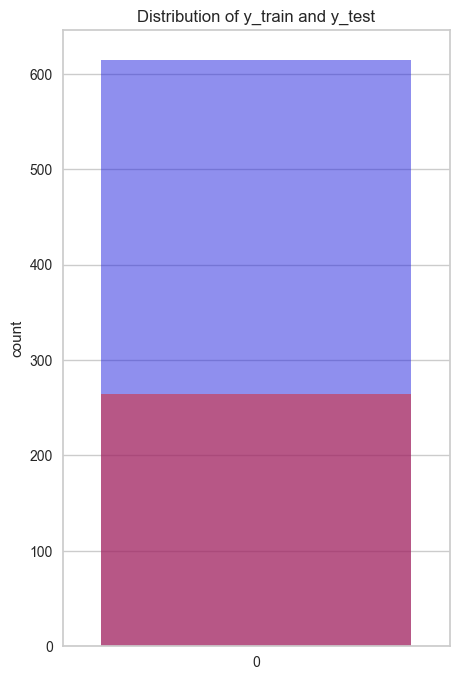

In [20]:
# X_train, y_train, X_test, y_test distribution plot
plt.figure(figsize=(5, 8))
plt.title('Distribution of y_train and y_test')
sns.countplot(y_train, color='blue', label='train', alpha=0.5)
sns.countplot(y_test, color='red', label='test', alpha=0.5)
plt.show()

# autoML

In [21]:
s = setup(datasheet, target=target, session_id=123)

,Description,Value
0,Session id,123
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(879, 7)"
4,Transformed data shape,"(879, 7)"
5,Transformed train set shape,"(615, 7)"
6,Transformed test set shape,"(264, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [22]:
exp = ClassificationExperiment()
exp.setup(data=datasheet, target=target)

,Description,Value
0,Session id,7278
1,Target,product_category
2,Target type,Multiclass
3,Original data shape,"(879, 7)"
4,Transformed data shape,"(879, 7)"
5,Transformed train set shape,"(615, 7)"
6,Transformed test set shape,"(264, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [23]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.2651,0.5000,0.2651,0.0704,0.1112,0.0000,0.0000,0.0140
ridge,Ridge Classifier,0.2604,0.0000,0.2604,0.1364,0.1737,0.0029,0.0053,0.0230
lda,Linear Discriminant Analysis,0.2588,0.5001,0.2588,0.1528,0.1779,0.0049,0.0076,0.0210
nb,Naive Bayes,0.2458,0.4929,0.2458,0.1391,0.1664,-0.0138,-0.0165,0.0150
lr,Logistic Regression,0.2439,0.5022,0.2439,0.1166,0.1429,-0.0234,-0.0311,0.2450
svm,SVM - Linear Kernel,0.2358,0.0000,0.2358,0.0715,0.0981,0.0056,0.0130,0.0210
knn,K Neighbors Classifier,0.2310,0.4983,0.2310,0.2065,0.2081,0.0060,0.0060,0.0330
lightgbm,Light Gradient Boosting Machine,0.2197,0.4916,0.2197,0.2059,0.2098,0.0086,0.0085,0.0390
ada,Ada Boost Classifier,0.2132,0.5220,0.2132,0.2003,0.1965,-0.0070,-0.0070,0.0310
gbc,Gradient Boosting Classifier,0.2099,0.5118,0.2099,0.1956,0.1991,-0.0070,-0.0074,0.0680


DummyClassifier(constant=None, random_state=123, strategy='prior')

# Random Forest Classification

In [68]:
classifier = RandomForestClassifier(n_estimators=5, max_depth=10, random_state=42, verbose=1, n_jobs=-1, max_leaf_nodes=1000)
classifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=1000, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=5, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=1, warm_start=False)

In [69]:
y_pred = classifier.predict(X_test)
mse_loss = mean_squared_error(y_test, y_pred)

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.24      0.23        70
           1       0.22      0.17      0.19        42
           2       0.27      0.37      0.31        65
           3       0.14      0.13      0.13        45
           4       0.13      0.07      0.09        28
           5       0.10      0.07      0.08        14

    accuracy                           0.22       264
   macro avg       0.18      0.18      0.17       264
weighted avg       0.20      0.22      0.21       264



In [71]:
y_pred_train = classifier.predict(X_train)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       163
           1       0.79      0.82      0.81        99
           2       0.80      0.87      0.83       151
           3       0.84      0.75      0.79       106
           4       0.85      0.70      0.77        64
           5       0.86      0.56      0.68        32

    accuracy                           0.80       615
   macro avg       0.82      0.76      0.78       615
weighted avg       0.81      0.80      0.80       615



[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


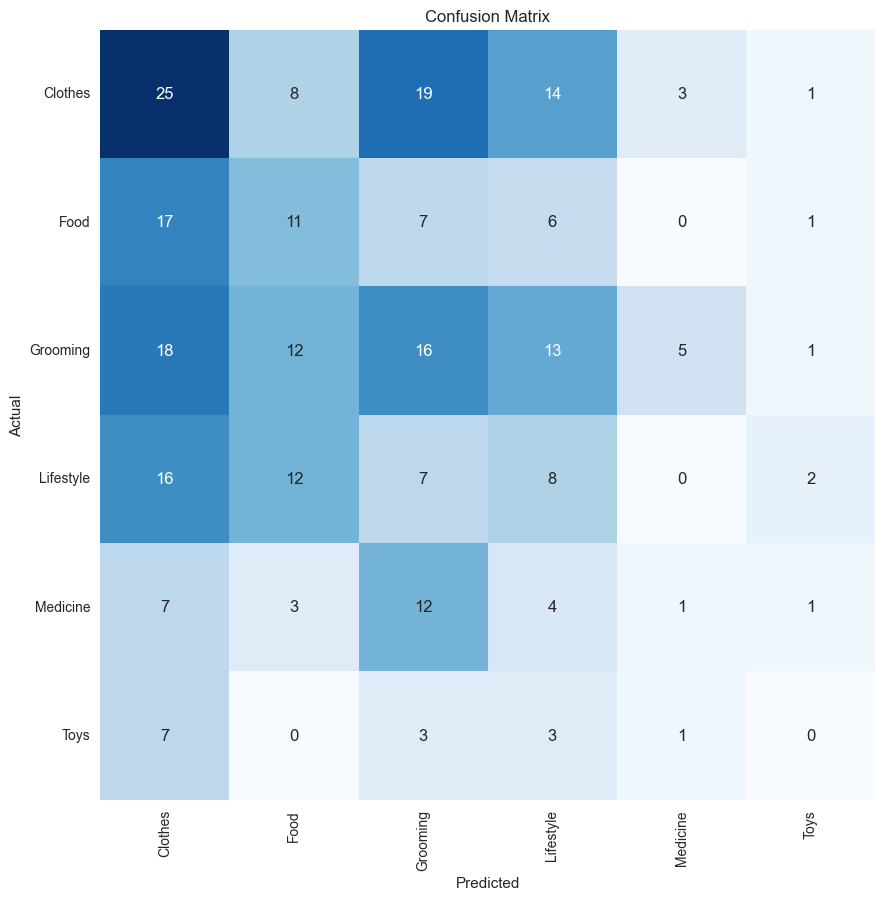

In [64]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
# ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

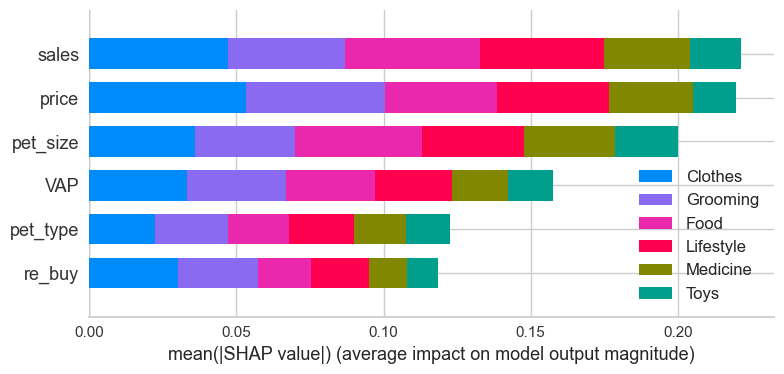

In [29]:
explainer = shap.TreeExplainer(classifier)
excepted_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

feature_names = list(datasheet.columns)[1:]
class_names = np.unique(org_product_category).tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names, plot_type="bar")

# Decision Tree Classification

In [30]:
classifier = DecisionTreeClassifier()

In [31]:
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

mse_loss = mean_squared_error(y_test, y_pred)
print("MSE Loss: ", mse_loss)

MSE Loss:  5.291666666666667


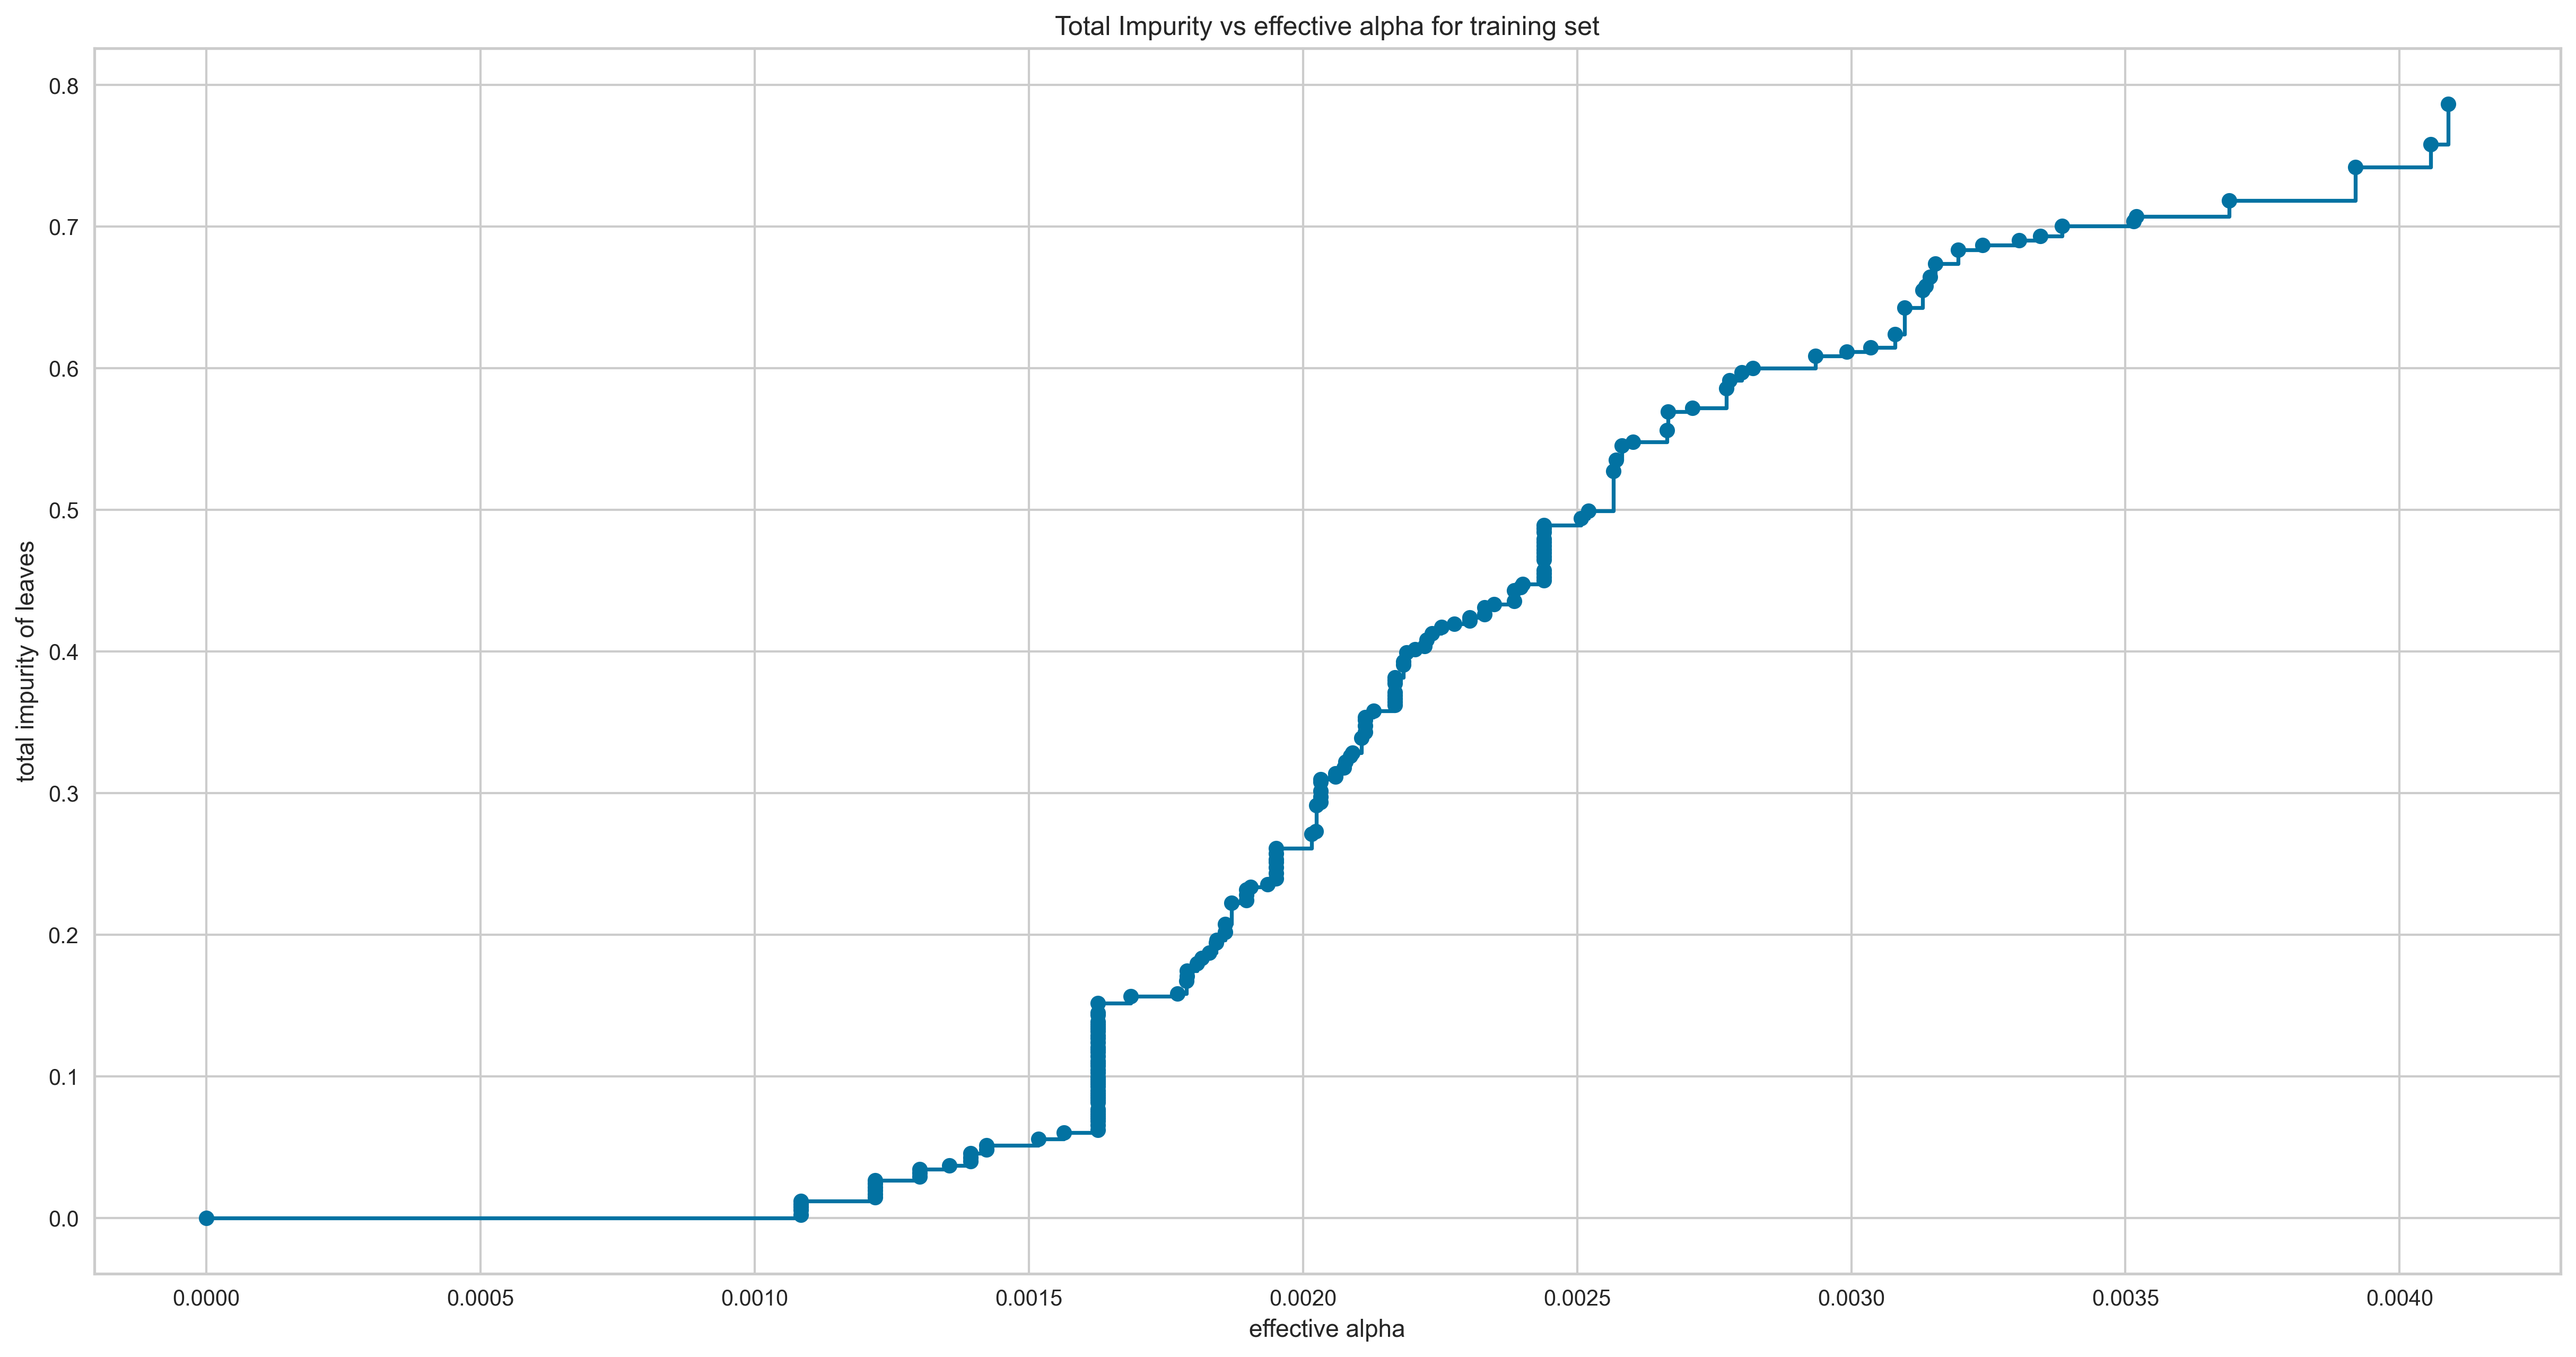

In [32]:
path = classifier.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
ax.set_xlabel('effective alpha')
ax.set_ylabel('total impurity of leaves')
ax.set_title('Total Impurity vs effective alpha for training set')
plt.show()

In [33]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.004529100145530022


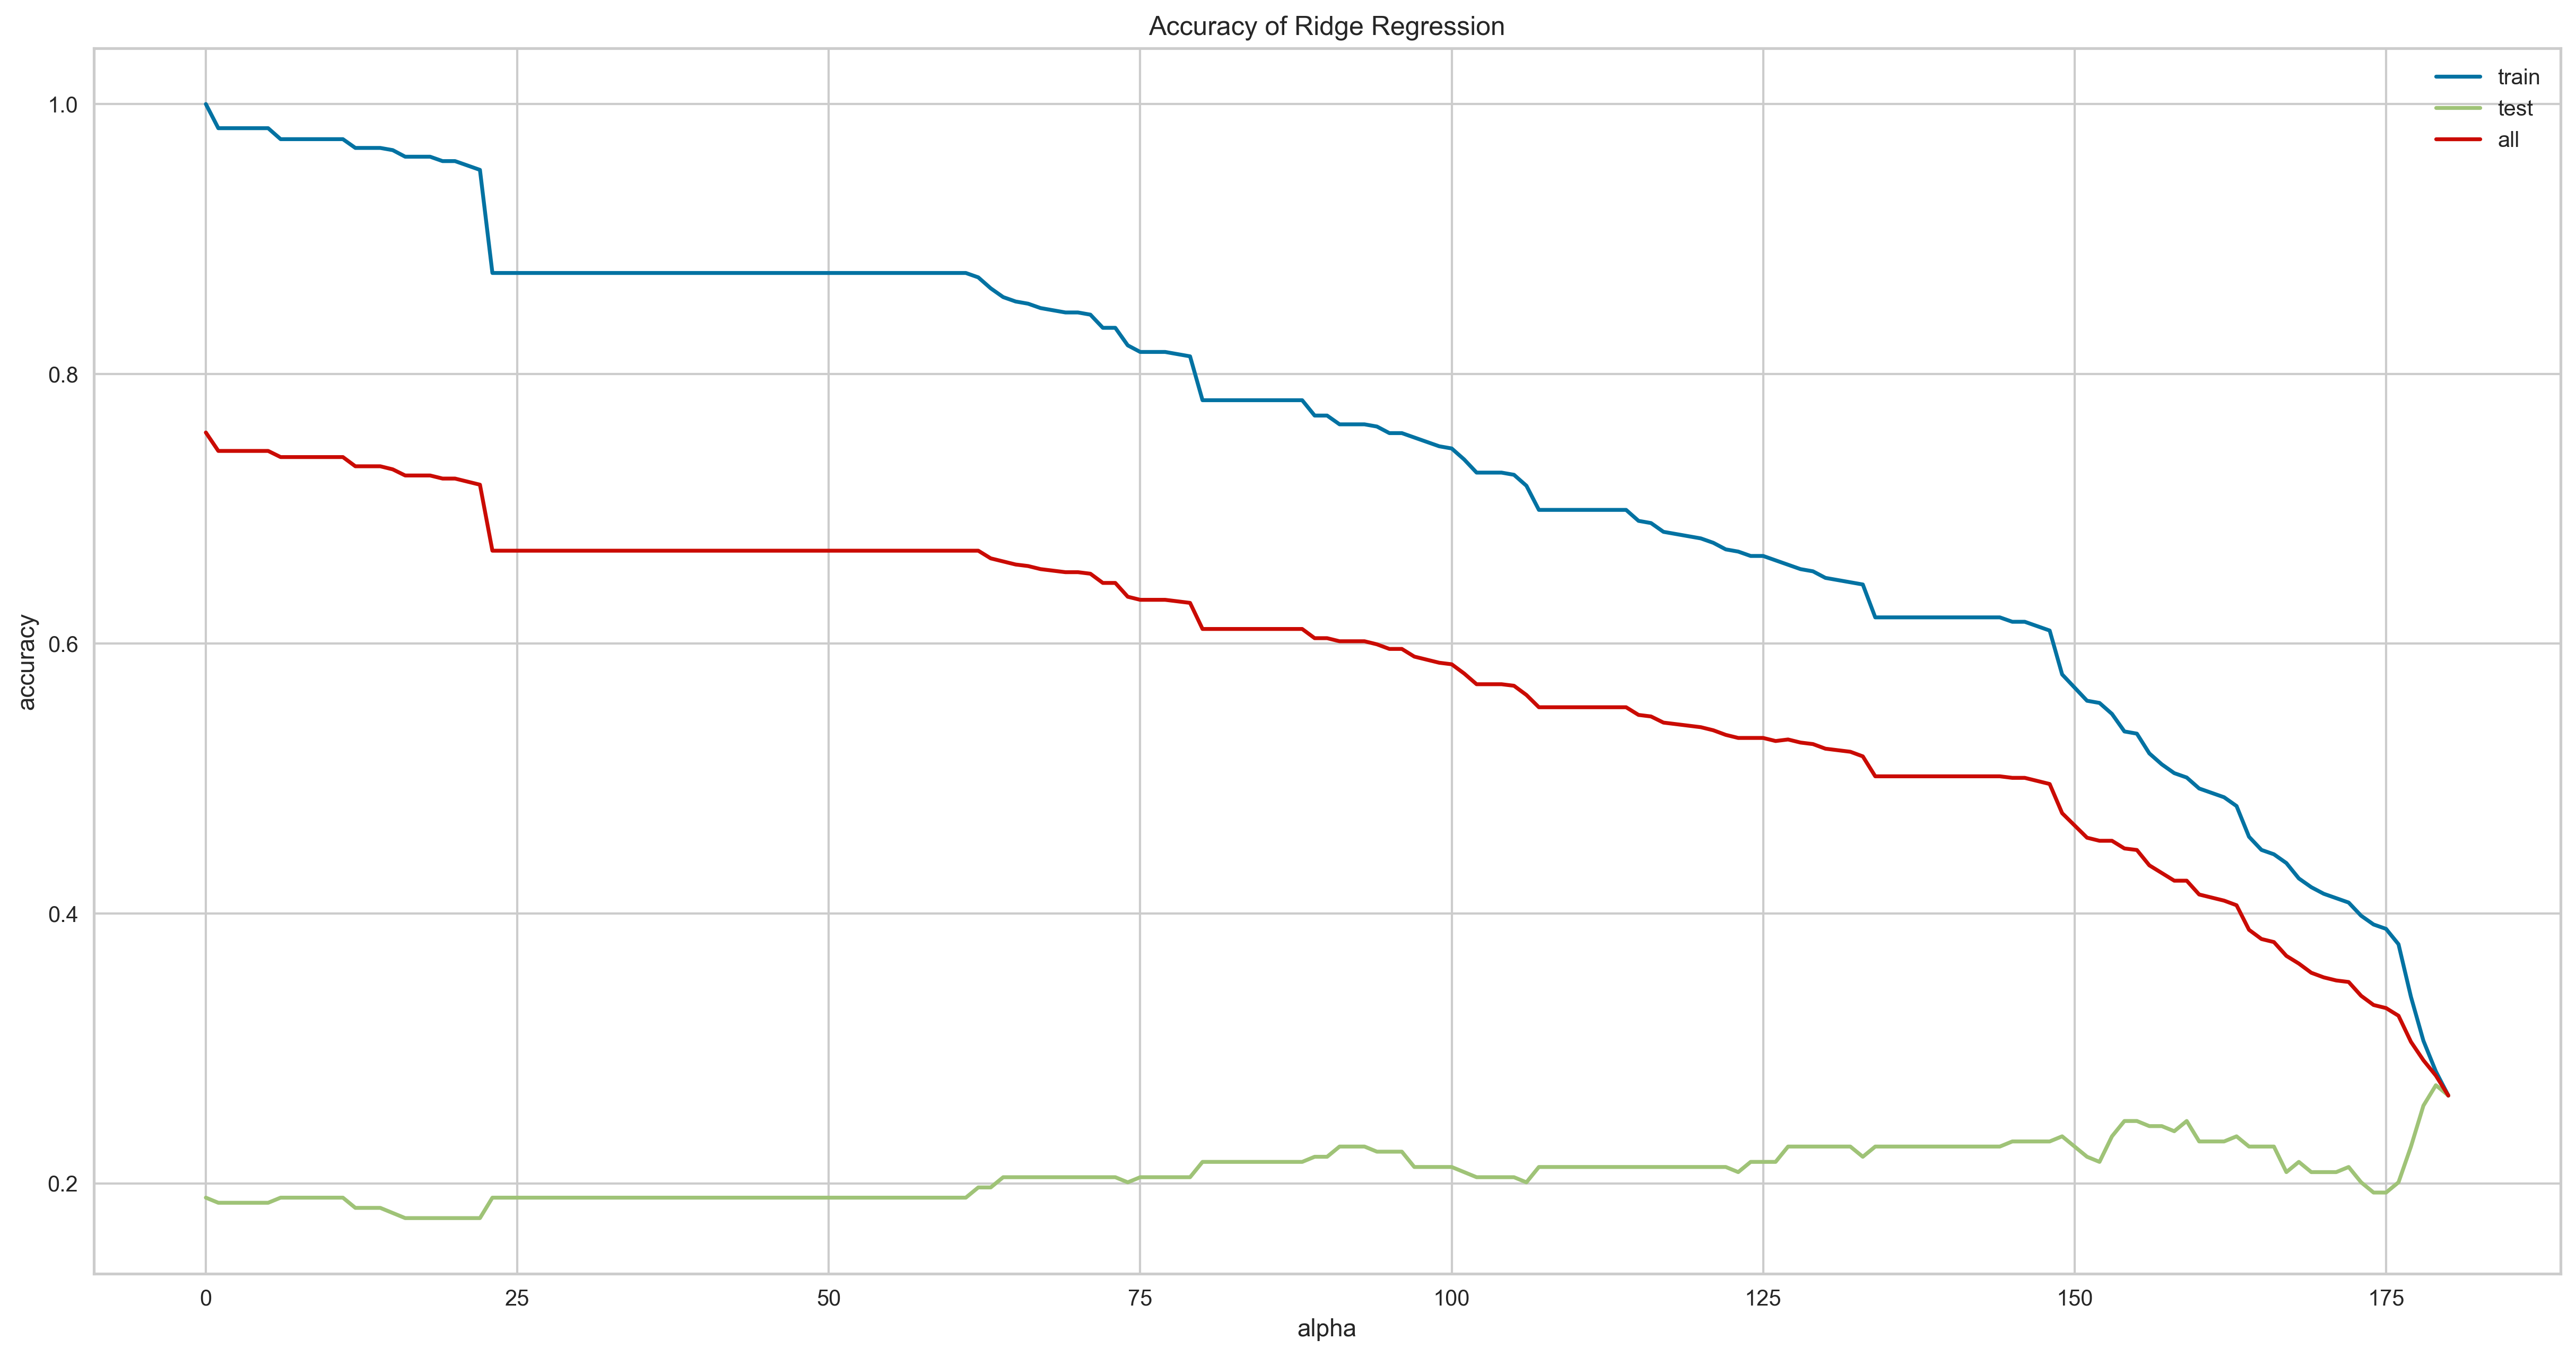

In [41]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
all_scores = [clf.score(X_data, y_data) for clf in clfs]

plt.figure(figsize=(20, 10), dpi=300)
plt.plot(train_scores, label='train')
plt.plot(test_scores, label='test')
plt.plot(all_scores, label='all')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.title('Accuracy of Ridge Regression')
plt.legend()
plt.show()

In [42]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.29      0.30      0.30        70
        Food       0.24      0.24      0.24        42
    Grooming       0.24      0.22      0.23        65
   Lifestyle       0.14      0.16      0.15        45
    Medicine       0.26      0.29      0.27        28
        Toys       0.00      0.00      0.00        14

    accuracy                           0.23       264
   macro avg       0.20      0.20      0.20       264
weighted avg       0.23      0.23      0.23       264



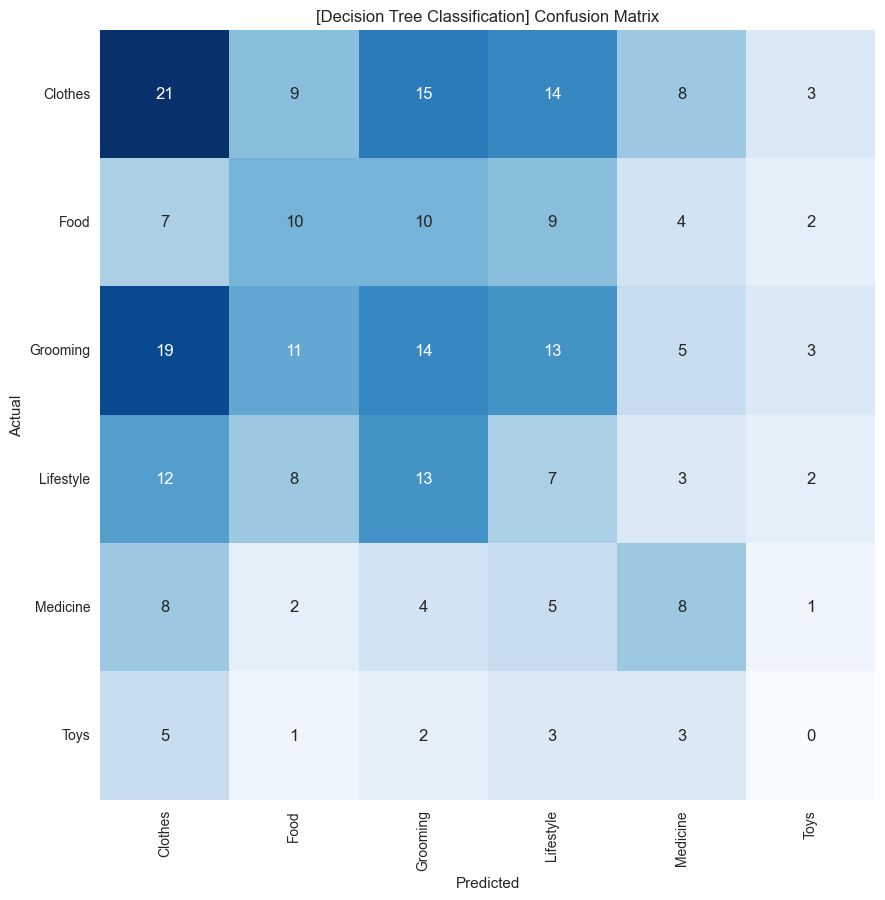

In [43]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
# ticks_labels.sort()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('[Decision Tree Classification] Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()

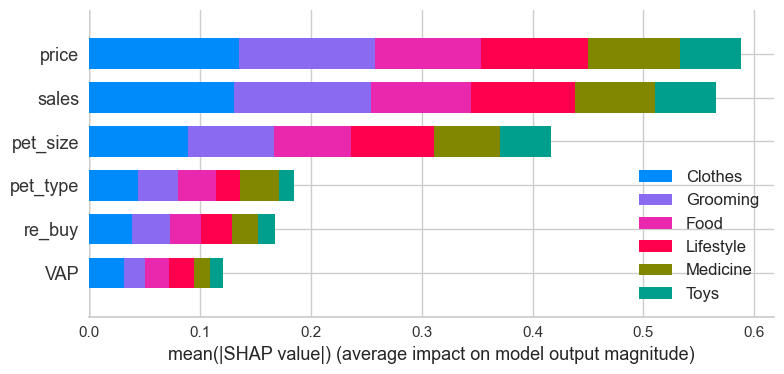

In [37]:
explainer = shap.TreeExplainer(classifier)
excepted_value = explainer.expected_value
shap_values = explainer.shap_values(X_test)

feature_names = list(datasheet.columns)[1:]
class_names = np.unique(org_product_category).tolist()
shap.summary_plot(shap_values, X_test, feature_names=feature_names, class_names=class_names, plot_type="bar")

# Dummy Classifier

In [73]:
dummy_classifier = DummyClassifier(strategy="uniform", random_state=42)
dummy_classifier.fit(X_train, y_train)

y_pred = dummy_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

Accuracy: 0.17803030303030304
Mean Squared Error: 5.693181818181818


In [74]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     Clothes       0.29      0.20      0.24        70
        Food       0.16      0.14      0.15        42
    Grooming       0.29      0.20      0.24        65
   Lifestyle       0.16      0.20      0.18        45
    Medicine       0.05      0.07      0.06        28
        Toys       0.07      0.21      0.11        14

    accuracy                           0.18       264
   macro avg       0.17      0.17      0.16       264
weighted avg       0.21      0.18      0.19       264



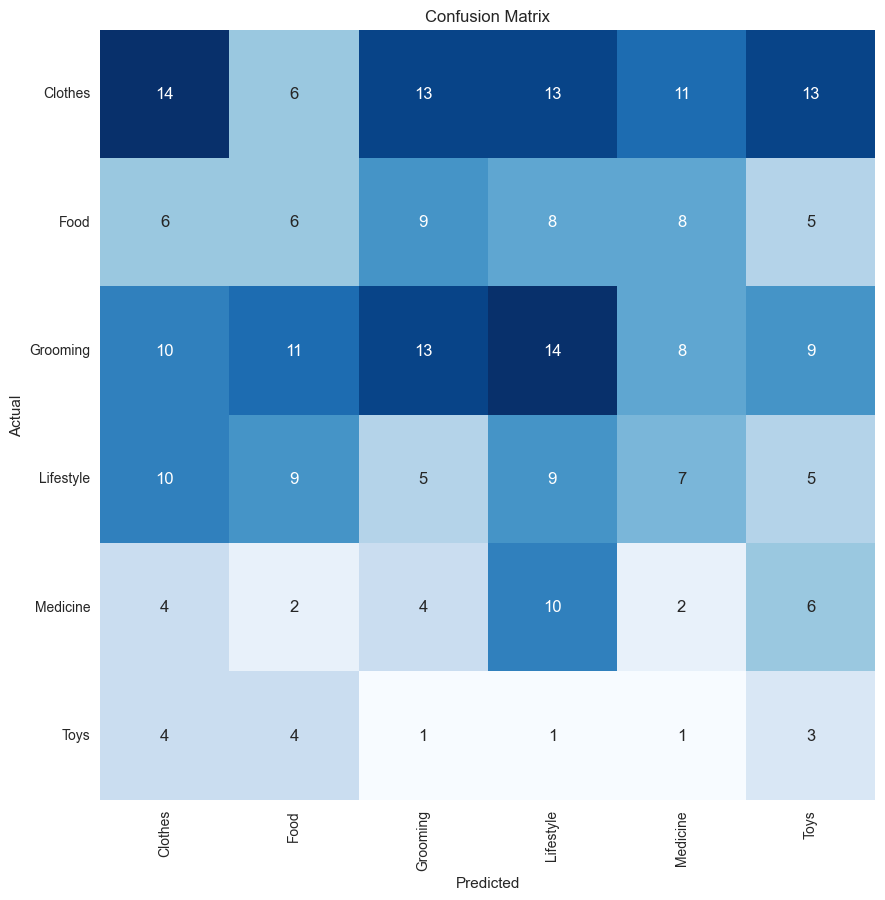

In [75]:
conf_mat = confusion_matrix(y_test, y_pred)
ticks_labels = np.unique(org_product_category).tolist()
ticks_labels = [str(i) for i in ticks_labels]

plt.figure(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=90)
plt.yticks(ticks=np.arange(len(ticks_labels))+0.5, labels=ticks_labels, rotation=0)
plt.show()